## Install and Imports

In [ ]:
!pip install tensorflow # Install PyTorch with CUDA support
!pip install torch torchvision torchaudio





In [ ]:
!pip uninstall torch-scatter torch-sparse torch-cluster torch-spline-conv -y
!pip uninstall torch-geometric -y

In [ ]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")


PyTorch version: 2.5.0+cu121
CUDA available: True
CUDA version: 12.1


In [ ]:
# Install PyTorch Geometric dependencies with pre-built binaries
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html

# Install torch-geometric
!pip install torch-geometric


Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 62.7 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 38.0 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 28.4 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.6/886.6 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 79.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.3 MB/s eta 0:00:00


In [ ]:
!pip install torchinfo


In [ ]:
import torch_geometric
from torch_geometric.data import Data
print("Torch Geometric version:", torch_geometric.__version__)


/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_spline_conv/_version_cuda.so: undefined symbol: _ZN3c1017Registe

Torch Geometric version: 2.6.1


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate

## Model Prossess data

In [ ]:
weather_data = pd.read_csv('Datasets/complete_KNN_dataset_corrected.csv')
topo_features = pd.read_csv('Datasets/topological_features_365d_gpus.csv')
soil_data= pd.read_csv('Datasets/table_static_data_selected.csv')

yield_soil = pd.read_csv('Datasets/corn2001_2023_yield_data.csv')
yield_data = yield_soil[['Year', 'County', 'Value']]


In [ ]:
yield_data = yield_data[~((yield_data['Year'] == 2012) & (yield_data['Value'] < 90))]


In [ ]:
yield_data= yield_data.rename(columns={'County': 'county'})

In [ ]:
soil_data = soil_data.rename(columns={'NAME_U': 'county'})

In [ ]:
import pandas as pd

# Assuming df_yield is your yield dataframe
# And all_counties is a list of all county names in your region/state
all_counties = soil_data['county'].unique()  # Use the list of all county names from weather_data

# Assuming 'Year' and 'county' are the columns that list the year and county names in df_yield
# Iterate over each unique year in the yield dataset
years = yield_data['Year'].unique()

new_rows = []

for year in years:
    # Step 1: Filter data for the specific year
    year_data = yield_data[yield_data['Year'] == year]

    # Identify counties already present for this specific year
    present_counties = year_data['county'].unique().tolist()

    # Step 2: Identify the missing counties for this specific year
    missing_counties = [county for county in all_counties if county not in present_counties]

    # Step 3: Extract the "Other counties" data from the year-specific dataframe
    # Handle different variations of the "Other counties" labels
    other_county_data = year_data[
        year_data['county'].str.contains(r'OTHER.*COUNTIES', case=False, na=False)
    ]

    # Ensure there is "Other counties" data for this year
    if other_county_data.empty:
        print(f"No 'Other counties' row found for year {year}.")
    else:
        # Step 4: Create new rows for the missing counties for this year
        for _, row in other_county_data.iterrows():
            for missing_county in missing_counties:
                new_row = row.copy()
                new_row['county'] = missing_county
                new_rows.append(new_row)

# Step 5: Convert the list of new rows to a DataFrame
new_rows_df = pd.DataFrame(new_rows)

# Step 6: Append new rows to the original yield_data
yield_data_expanded = pd.concat([yield_data, new_rows_df], ignore_index=True)

# Step 7: Reset the index if needed
yield_data_expanded.reset_index(drop=True, inplace=True)

# Print to confirm changes (optional)
yield_data_expanded


No 'Other counties' row found for year 2010.


,Year,county,Value
0,2023,OTHER COUNTIES,202.5
1,2023,BARTHOLOMEW,195.0
2,2023,BOONE,207.2
3,2023,CLINTON,234.4
4,2023,DECATUR,221.9
...,...,...,...
2677,2001,BROWN,133.2
2678,2001,OHIO,133.2
2679,2001,SWITZERLAND,133.2
2680,2001,CRAWFORD,133.2


In [ ]:
# Filtering rows where 'Value' is less than 100
rows_below_100 = yield_data_expanded[yield_data_expanded['Year'] ==2012]

# Display the rows
rows_below_100

,Year,county,Value
915,2012,BOONE,91.6
916,2012,CLINTON,148.0
917,2012,HAMILTON,121.9
918,2012,HANCOCK,90.5
919,2012,HOWARD,154.2
...,...,...,...
2538,2012,PERRY,112.2
2539,2012,WARRICK,112.2
2540,2012,POSEY,112.2
2541,2012,SPENCER,112.2


In [ ]:
for year in years:
    # Step 1: Filter data for the specific year
    year_data = yield_data_expanded[yield_data_expanded['Year'] == year]

    print(f"Counties available for year {year}: {year_data['county'].unique()}")  # Debug printout

    # The rest of the code continues here...


Counties available for year 2023: ['OTHER COUNTIES' 'BARTHOLOMEW' 'BOONE' 'CLINTON' 'DECATUR' 'GRANT'
 'HAMILTON' 'HANCOCK' 'HENDRICKS' 'HOWARD' 'JOHNSON' 'MADISON' 'MARION'
 'MORGAN' 'RUSH' 'SHELBY' 'TIPTON' 'BLACKFORD' 'DELAWARE' 'FAYETTE'
 'HENRY' 'JAY' 'RANDOLPH' 'UNION' 'WAYNE' 'ELKHART' 'KOSCIUSKO' 'MARSHALL'
 'MIAMI' 'ST. JOSEPH' 'WABASH' 'ADAMS' 'ALLEN' 'HUNTINGTON' 'LAGRANGE'
 'NOBLE' 'STEUBEN' 'WELLS' 'WHITLEY' 'BENTON' 'JASPER' 'LA PORTE' 'LAKE'
 'NEWTON' 'PORTER' 'PULASKI' 'STARKE' 'WHITE' 'BROWN' 'HARRISON' 'MONROE'
 'CLARK' 'DEARBORN' 'FRANKLIN' 'JEFFERSON' 'JENNINGS' 'OHIO' 'RIPLEY'
 'SCOTT' 'SWITZERLAND' 'DAVIESS' 'GIBSON' 'GREENE' 'KNOX' 'PIKE' 'POSEY'
 'SULLIVAN' 'VANDERBURGH' 'WARRICK' 'CLAY' 'MONTGOMERY' 'OWEN' 'PUTNAM'
 'TIPPECANOE' 'VIGO' 'ST JOSEPH' 'DE KALB' 'FULTON' 'CASS' 'CARROLL'
 'WARREN' 'FOUNTAIN' 'VERMILLION' 'PARKE' 'JACKSON' 'LAWRENCE' 'MARTIN'
 'WASHINGTON' 'ORANGE' 'DUBOIS' 'CRAWFORD' 'FLOYD' 'PERRY' 'SPENCER']
Counties available for year 2022: ['OTH

In [ ]:
import geopandas as gpd

# Load the county shapefile
counties = gpd.read_file('Datasets/Census_County_TIGER00_IN.shp')
counties = counties.rename(columns={'NAME_U': 'county'})

In [ ]:
soil_data = soil_data[['county', 'aws0_5', 'aws5_20',
       'aws20_50', 'aws0_20', 'soc0_20', 'soc0_30',
       'nccpi3corn', 'slope_r', 'elev_r',
        'W_avg_silt', 'W_avg_clay']]

In [ ]:
# Get the unique counties from weather_data
valid_counties = weather_data['county'].unique()

# Filter soil_data to include only counties present in weather_data
soil_data_filtered = soil_data[soil_data['county'].isin(valid_counties)]

# Filter yield_data to include only counties present in weather_data
yield_data_filtered = yield_data_expanded[yield_data_expanded['county'].isin(valid_counties)]

# Now you have filtered versions of both soil_data and yield_data that contain only relevant counties
print(f"Filtered soil_data contains {len(soil_data_filtered)} rows")
print(f"Filtered yield_data contains {len(yield_data_filtered)} rows")


Filtered soil_data contains 81 rows
Filtered yield_data contains 2264 rows


In [ ]:
import pandas as pd

# Assuming weather_data is already loaded
weather_data['Date'] = pd.to_datetime(weather_data['Date'])  # Ensure 'Date' column is in datetime format
weather_data['year'] = weather_data['Date'].dt.year          # Extract year
weather_data['month'] = weather_data['Date'].dt.month        # Extract month

# Filter to keep only rows where month is between April (4) and August (8)
filtered_weather_data = weather_data[(weather_data['month'] >= 4) & (weather_data['month'] <= 8)]

filtered_weather_data

,Date,county,mergedmax_temp,mergedmean_temp,mergedmin_temp,merged_precip,gdd,year,month
90,2001-04-01,ADAMS,48.0,41.0,34.0,0.190000,0.0,2001,4
91,2001-04-02,ADAMS,59.0,43.5,28.0,0.000000,0.0,2001,4
92,2001-04-03,ADAMS,54.0,47.0,40.0,0.000000,0.0,2001,4
93,2001-04-04,ADAMS,59.0,45.5,32.0,0.000000,0.0,2001,4
94,2001-04-05,ADAMS,73.0,53.0,33.0,0.000000,3.0,2001,4
...,...,...,...,...,...,...,...,...,...
535044,2023-08-27,WHITLEY,75.0,64.0,53.0,0.000000,14.0,2023,8
535045,2023-08-28,WHITLEY,76.0,63.5,51.0,0.000000,13.5,2023,8
535046,2023-08-29,WHITLEY,80.0,65.5,51.0,0.020000,15.5,2023,8
535047,2023-08-30,WHITLEY,71.0,59.5,48.0,0.071667,9.5,2023,8


In [ ]:
# Get the unique counties from each dataset
weather_counties = set(filtered_weather_data['county'].unique())
soil_counties = set(soil_data_filtered['county'].unique())  # Use the filtered version
yield_counties = set(yield_data_filtered['county'].unique())  # Use the filtered version

# Check for differences
counties_in_weather_not_in_soil = weather_counties - soil_counties
counties_in_soil_not_in_weather = soil_counties - weather_counties

counties_in_weather_not_in_yield = weather_counties - yield_counties
counties_in_yield_not_in_weather = yield_counties - weather_counties

# Print the results
print(f"Counties in weather data but not in soil data: {counties_in_weather_not_in_soil}")
print(f"Counties in soil data but not in weather data: {counties_in_soil_not_in_weather}")

print(f"Counties in weather data but not in yield data: {counties_in_weather_not_in_yield}")
print(f"Counties in yield data but not in weather data: {counties_in_yield_not_in_weather}")


Counties in weather data but not in soil data: set()
Counties in soil data but not in weather data: set()
Counties in weather data but not in yield data: set()
Counties in yield data but not in weather data: set()


In [ ]:
yield_counties

{'ADAMS',
 'ALLEN',
 'BARTHOLOMEW',
 'BENTON',
 'BLACKFORD',
 'BOONE',
 'CARROLL',
 'CASS',
 'CLAY',
 'CLINTON',
 'CRAWFORD',
 'DAVIESS',
 'DEARBORN',
 'DECATUR',
 'DELAWARE',
 'DUBOIS',
 'ELKHART',
 'FOUNTAIN',
 'FRANKLIN',
 'FULTON',
 'GIBSON',
 'GRANT',
 'HAMILTON',
 'HANCOCK',
 'HENRY',
 'HOWARD',
 'HUNTINGTON',
 'JACKSON',
 'JASPER',
 'JAY',
 'JEFFERSON',
 'JENNINGS',
 'JOHNSON',
 'KNOX',
 'KOSCIUSKO',
 'LA PORTE',
 'LAGRANGE',
 'LAKE',
 'LAWRENCE',
 'MADISON',
 'MARION',
 'MARSHALL',
 'MARTIN',
 'MONROE',
 'MONTGOMERY',
 'MORGAN',
 'NEWTON',
 'NOBLE',
 'ORANGE',
 'OWEN',
 'PARKE',
 'PERRY',
 'PIKE',
 'PORTER',
 'POSEY',
 'PULASKI',
 'PUTNAM',
 'RANDOLPH',
 'RIPLEY',
 'RUSH',
 'SCOTT',
 'SHELBY',
 'SPENCER',
 'ST JOSEPH',
 'STARKE',
 'STEUBEN',
 'SULLIVAN',
 'SWITZERLAND',
 'TIPPECANOE',
 'TIPTON',
 'UNION',
 'VANDERBURGH',
 'VERMILLION',
 'VIGO',
 'WABASH',
 'WARRICK',
 'WASHINGTON',
 'WAYNE',
 'WELLS',
 'WHITE',
 'WHITLEY'}

In [ ]:
weather_data = filtered_weather_data.rename(columns={'Date': 'date'})

In [ ]:
weather_data['date'] = pd.to_datetime(weather_data['date'])

In [ ]:
weather_data['year'] = weather_data['date'].dt.year

In [ ]:
# Convert the 'date' column to datetime if it's not already in datetime format
weather_data['date'] = pd.to_datetime(weather_data['date'])

# Extract the month from the 'date' column
weather_data['month'] = weather_data['date'].dt.month

# Filter the weather data to include only records from January to September (month <= 9)
weather_data_up_to_september = weather_data[weather_data['month'] <= 9]

# Optionally drop the 'month' column if no longer needed
weather_data = weather_data_up_to_september.drop(columns=['month'])

# Check the filtered data
weather_data

,date,county,mergedmax_temp,mergedmean_temp,mergedmin_temp,merged_precip,gdd,year
90,2001-04-01,ADAMS,48.0,41.0,34.0,0.190000,0.0,2001
91,2001-04-02,ADAMS,59.0,43.5,28.0,0.000000,0.0,2001
92,2001-04-03,ADAMS,54.0,47.0,40.0,0.000000,0.0,2001
93,2001-04-04,ADAMS,59.0,45.5,32.0,0.000000,0.0,2001
94,2001-04-05,ADAMS,73.0,53.0,33.0,0.000000,3.0,2001
...,...,...,...,...,...,...,...,...
535044,2023-08-27,WHITLEY,75.0,64.0,53.0,0.000000,14.0,2023
535045,2023-08-28,WHITLEY,76.0,63.5,51.0,0.000000,13.5,2023
535046,2023-08-29,WHITLEY,80.0,65.5,51.0,0.020000,15.5,2023
535047,2023-08-30,WHITLEY,71.0,59.5,48.0,0.071667,9.5,2023


In [ ]:
yield_data = yield_data_expanded.rename(columns={'Year': 'year'})

In [ ]:
# Check common counties and years
weather_data['county'] = weather_data['county'].str.strip()  # clean up names if needed
topo_features['county'] = topo_features['county'].str.strip()
yield_data['county'] = yield_data['county'].str.strip()
soil_data['county'] = soil_data['county'].str.strip()

# Check if all counties are present in each dataset
print(set(weather_data['county']).intersection(set(topo_features['county'])))
print(set(weather_data['county']).intersection(set(yield_data['county'])))
print(set(weather_data['county']).intersection(set(soil_data['county'])))


{'KOSCIUSKO', 'SULLIVAN', 'FRANKLIN', 'BOONE', 'DECATUR', 'CRAWFORD', 'WARRICK', 'SHELBY', 'CLINTON', 'MARSHALL', 'HUNTINGTON', 'STARKE', 'GRANT', 'VANDERBURGH', 'ADAMS', 'BENTON', 'WELLS', 'ELKHART', 'VIGO', 'MADISON', 'WHITLEY', 'WABASH', 'DUBOIS', 'CASS', 'LAGRANGE', 'ALLEN', 'VERMILLION', 'ST JOSEPH', 'POSEY', 'PULASKI', 'JASPER', 'CLAY', 'STEUBEN', 'LA PORTE', 'JOHNSON', 'DAVIESS', 'RIPLEY', 'WASHINGTON', 'UNION', 'MARTIN', 'SPENCER', 'JENNINGS', 'DEARBORN', 'CARROLL', 'JEFFERSON', 'TIPPECANOE', 'NEWTON', 'LAKE', 'NOBLE', 'SWITZERLAND', 'LAWRENCE', 'PORTER', 'MORGAN', 'MARION', 'OWEN', 'PARKE', 'MONROE', 'MONTGOMERY', 'RANDOLPH', 'BLACKFORD', 'HANCOCK', 'PERRY', 'HENRY', 'GIBSON', 'PIKE', 'DELAWARE', 'FULTON', 'SCOTT', 'KNOX', 'FOUNTAIN', 'TIPTON', 'HAMILTON', 'RUSH', 'HOWARD', 'WAYNE', 'PUTNAM', 'BARTHOLOMEW', 'WHITE', 'JACKSON', 'ORANGE', 'JAY'}
{'KOSCIUSKO', 'SULLIVAN', 'FRANKLIN', 'BOONE', 'DECATUR', 'CRAWFORD', 'WARRICK', 'SHELBY', 'CLINTON', 'MARSHALL', 'HUNTINGTON', 'STARKE

In [ ]:
yield_data.columns

Index(['year', 'county', 'Value'], dtype='object')

In [ ]:
# Merge weather, topological, soil, and yield data on county and year
merged_data = pd.merge(yield_data, weather_data, on=['county', 'year'], how='inner')
merged_data = pd.merge(merged_data, topo_features, on=['county', 'year'], how='inner')
merged_data = pd.merge(merged_data, soil_data, on='county', how='inner')

# The final merged data will have one row per county per year with all features and the target yield
print(merged_data.columns)


Index(['year', 'county', 'Value', 'date', 'mergedmax_temp', 'mergedmean_temp',
       'mergedmin_temp', 'merged_precip', 'gdd', 'BirthMean_0', 'DeathMean_0',
       'LifeMean_0', 'NumBar_0', 'BirthMean_1', 'DeathMean_1', 'LifeMean_1',
       'NumBar_1', 'DistQ0', 'DistQ1', 'DistQ2', 'DistQ3', 'DistQ4',
       'CosSimQ0', 'CosSimQ1', 'CosSimQ2', 'CosSimQ3', 'CosSimQ4', 'aws0_5',
       'aws5_20', 'aws20_50', 'aws0_20', 'soc0_20', 'soc0_30', 'nccpi3corn',
       'slope_r', 'elev_r', 'W_avg_silt', 'W_avg_clay'],
      dtype='object')


In [ ]:
merged_data = merged_data.rename(columns={'mergedmax_temp': 'max', 'mergedmean_temp': 'meantemp','mergedmin_temp': 'min', 'merged_precip': 'rainfall'})

In [ ]:
merged_data.columns

Index(['year', 'county', 'Value', 'date', 'max', 'meantemp', 'min', 'rainfall',
       'gdd', 'BirthMean_0', 'DeathMean_0', 'LifeMean_0', 'NumBar_0',
       'BirthMean_1', 'DeathMean_1', 'LifeMean_1', 'NumBar_1', 'DistQ0',
       'DistQ1', 'DistQ2', 'DistQ3', 'DistQ4', 'CosSimQ0', 'CosSimQ1',
       'CosSimQ2', 'CosSimQ3', 'CosSimQ4', 'aws0_5', 'aws5_20', 'aws20_50',
       'aws0_20', 'soc0_20', 'soc0_30', 'nccpi3corn', 'slope_r', 'elev_r',
       'W_avg_silt', 'W_avg_clay'],
      dtype='object')

In [ ]:
import geopandas as gpd

# Check if county names match between merged_data and counties
merged_data['county'] = merged_data['county'].str.strip()
counties['county'] = counties['county'].str.strip()

# Ensure alignment of county names between the two dataframes
common_counties = set(merged_data['county']).intersection(set(counties['county']))
print(f'Number of common counties: {len(common_counties)}')


Number of common counties: 81


## Model Starts

In [ ]:
import numpy as np

# Create an empty distance matrix for the counties
n_counties = len(counties)
distance_matrix = np.zeros((n_counties, n_counties))

# Calculate the geographical distance between the polygons (county boundaries)
for i, county_i in enumerate(counties.geometry):
    for j, county_j in enumerate(counties.geometry):
        if i != j:
            # Calculate the minimum distance between two county polygons
            distance_matrix[i, j] = county_i.distance(county_j)

# Add county names to the matrix for easier interpretation
county_names = counties['county'].tolist()


In [ ]:
# Define a threshold (e.g., 50 km) to consider counties as "neighbors"
distance_threshold = 50  # kilometers

# Create an adjacency matrix where 1 indicates a connection and 0 means no connection
adjacency_matrix = (distance_matrix < distance_threshold).astype(int)

# Optional: Set diagonal elements to 0 (to avoid self-loops)
np.fill_diagonal(adjacency_matrix, 0)

# Convert the adjacency matrix to a sparse edge list (needed for GNN input)
edge_list = np.transpose(np.nonzero(adjacency_matrix))


In [ ]:
# Select relevant feature columns from merged_data for node features
node_features_columns = ['rainfall', 'max', 'min', 'meantemp', 'gdd',
                         'BirthMean_0', 'DeathMean_0', 'LifeMean_0', 'NumBar_0',
                         'BirthMean_1', 'DeathMean_1', 'LifeMean_1', 'NumBar_1',
                         'DistQ0', 'DistQ1', 'DistQ2', 'DistQ3', 'DistQ4',
                         'CosSimQ0', 'CosSimQ1', 'CosSimQ2', 'CosSimQ3', 'CosSimQ4',
                         'aws0_5', 'aws5_20', 'aws20_50', 'aws0_20', 'soc0_20',
                         'soc0_30', 'nccpi3corn', 'slope_r', 'elev_r', 'W_avg_silt',
                         'W_avg_clay']

# Extract node features for all counties and years
node_features = merged_data[node_features_columns].values


In [ ]:
import torch
from torch_geometric.data import Data

# Convert node features to a tensor
node_features_tensor = torch.tensor(node_features, dtype=torch.float)

# Convert the edge list to a tensor
edge_list_tensor = torch.tensor(edge_list.T, dtype=torch.long)  # .T to transpose into the correct shape

# Convert yield (target) values to a tensor
target = torch.tensor(merged_data['Value'].values, dtype=torch.float).unsqueeze(1)




In [ ]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')



Using device: cuda


Using device: cuda
County-Year Pairs in the Test Set (50 samples):
             county  year
16732        FULTON  2021
206578        GRANT  2019
157236     LAWRENCE  2005
175260     MARSHALL  2003
117690     FOUNTAIN  2009
84062        HOWARD  2012
254258      DAVIESS  2012
250871   VERMILLION  2012
170117  VANDERBURGH  2004
52524          CASS  2016
103881        WHITE  2010
240648     LAWRENCE  2013
143604       FULTON  2006
71951        ORANGE  2014
90886      RANDOLPH  2011
101088      ELKHART  2010
8601       DELAWARE  2022
157211     LAWRENCE  2005
158944         PIKE  2005
151380     HAMILTON  2005
72967        DUBOIS  2014
143921     MARSHALL  2006
59197     BLACKFORD  2015
15799     BLACKFORD  2021
52296      RANDOLPH  2016
79966        STARKE  2013
115993      DAVIESS  2009
10576      LA PORTE  2022
51711     BLACKFORD  2016
118396       PUTNAM  2009
151058      DECATUR  2005
128849        PARKE  2008
139688   TIPPECANOE  2007
135966      JACKSON  2007
190249         KNOX  20

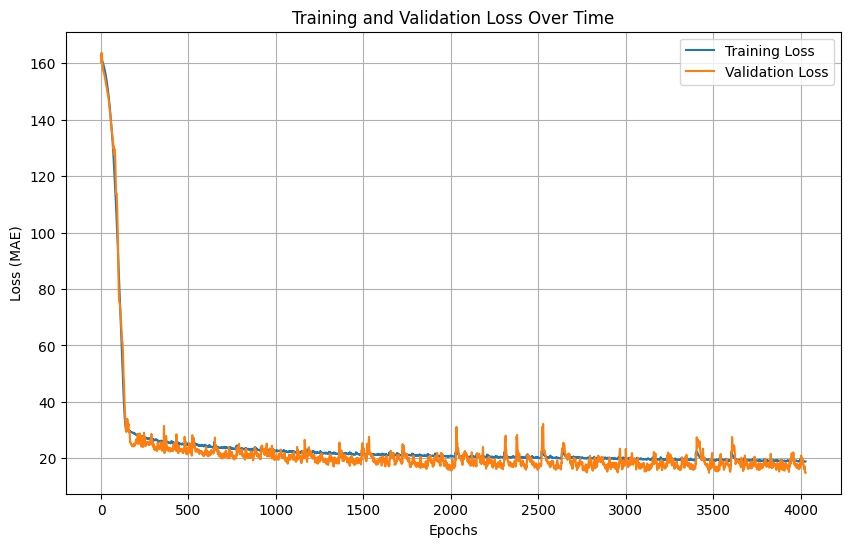

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import BatchNorm
import torch.optim.lr_scheduler as lr_scheduler

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# YieldGNN model definition
# Adding batch normalization layers
class YieldGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(YieldGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = BatchNorm(hidden_dim)
        self.conv2 = GCNConv(hidden_dim, int(hidden_dim/2))
        self.bn2 = BatchNorm(int(hidden_dim/2))
        self.conv3 = GCNConv(int(hidden_dim/2), int(hidden_dim/4))
        self.bn3 = BatchNorm(int(hidden_dim/4))
        self.conv4 = GCNConv(int(hidden_dim/4), int(hidden_dim/8))
        self.bn4 = BatchNorm(int(hidden_dim/8))
        self.fc = nn.Linear(int(hidden_dim/8), output_dim)

        self.dropout = nn.Dropout(p=0.2)

    def forward(self, data):
        x = self.conv1(data.x, data.edge_index)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, data.edge_index)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, data.edge_index)
        x = self.bn3(x)
        x = torch.relu(x)
        x = self.dropout(x)

        x = self.conv4(x, data.edge_index)
        x = self.bn4(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x= self.fc(x)

        return x

class EarlyStopping:
    def __init__(self, patience=10, min_delta=3, target_loss=15):
        """
        Early stopping to stop training when the validation loss does not improve
        after a certain number of epochs and the loss is below a target threshold.

        Args:
        - patience (int): How many epochs to wait before stopping when the loss is not improving.
        - min_delta (float): Minimum change to qualify as an improvement.
        - target_loss (float): The target validation loss to stop training once achieved.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.target_loss = target_loss
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        # If the validation loss is below the target loss threshold, check for stopping conditions
        if val_loss <= self.target_loss:
            if self.best_loss is None:
                self.best_loss = val_loss
            elif val_loss > self.best_loss - self.min_delta:
                self.counter += 1
                if self.counter >= self.patience:
                    print(f"Early stopping triggered at validation loss {val_loss}")
                    self.early_stop = True
            else:
                self.best_loss = val_loss
                self.counter = 0
        else:
            # Reset patience counter if the loss is not below the target_loss threshold
            self.counter = 0


# Assuming node_features, edge_list, and target (yield data) have already been defined

# Convert node features and edge list to tensors
node_features_tensor = torch.tensor(node_features, dtype=torch.float).to(device)  # Move to GPU
edge_list_tensor = torch.tensor(edge_list.T, dtype=torch.long).to(device)  # Move to GPU
target = torch.tensor(merged_data['Value'].values, dtype=torch.float).unsqueeze(1).to(device)  # Move to GPU

# Create a PyTorch Geometric Data object
data = Data(x=node_features_tensor, edge_index=edge_list_tensor, y=target).to(device)

# Train/validation split
# train_idx, val_idx = train_test_split(np.arange(len(target)), test_size=0.2, random_state=42)

# Desired number of test samples
desired_test_size = 50

# Get indices for the entire dataset
num_nodes = len(target)
all_indices = np.arange(num_nodes)

# First split into train and temporary (for validation and test)
train_idx, temp_idx = train_test_split(all_indices, test_size=(desired_test_size + int(0.15 * num_nodes)), random_state=42)

# Now split temp_idx into validation and exact 50-sized test set
val_idx, test_idx = train_test_split(temp_idx, test_size=desired_test_size, random_state=42)

# Create train, validation, and test masks
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_idx] = True

val_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask[val_idx] = True

test_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask[test_idx] = True

# Move masks to GPU if available
train_mask, val_mask, test_mask = train_mask.to(device), val_mask.to(device), test_mask.to(device)


test_county_year_pairs = merged_data.iloc[test_idx][['county', 'year']]

# Display the 50 county-year pairs in the test set
print("County-Year Pairs in the Test Set (50 samples):")
print(test_county_year_pairs)

# Initialize the model, optimizer, and MAE loss function
input_dim = node_features.shape[1]
hidden_dim = 256
output_dim = 1

model = YieldGNN(input_dim, hidden_dim, output_dim).to(device)  # Move model to GPU

optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-9)

# Define RMSE as the loss function
class RMSELoss(nn.Module):
    def forward(self, predictions, targets):
        mse_loss = nn.MSELoss()(predictions, targets)
        rmse_loss = torch.sqrt(mse_loss)
        return rmse_loss

# Use RMSELoss as the main loss function
loss_fn = RMSELoss()
# loss_fn = nn.L1Loss()  # Mean Absolute Error (MAE)
#scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, min_lr=1e-6)
# Initialize early stopping
early_stopping = EarlyStopping(patience=1, min_delta=3, target_loss=15)

# Training loop with validation
epochs = 20000
train_losses = []
val_losses = []

for epoch in range(epochs):
    # ---- TRAINING ----
    model.train()
    optimizer.zero_grad()

    # Forward pass on the training set
    train_output = model(data)

    # Compute loss for training data (only use the nodes in train_mask)
    train_loss = loss_fn(train_output[train_mask], data.y[train_mask])

    # Backpropagation
    train_loss.backward()
    optimizer.step()

    # Store training loss for plotting
    train_losses.append(train_loss.item())

    # ---- VALIDATION ----
    model.eval()  # Set model to evaluation mode (turns off dropout, etc.)
    with torch.no_grad():  # No need to calculate gradients for validation
        val_output = model(data)
        val_loss = loss_fn(val_output[val_mask], data.y[val_mask])
    # scheduler.step(val_loss.item())
    # Store validation loss for plotting
    val_losses.append(val_loss.item())

    # Print loss every 50 epochs
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Training RMSE Loss: {train_loss.item()}, Validation RMSE Loss: {val_loss.item()}')

    # Check for early stopping
    early_stopping(val_loss.item())
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch} ; Training RMSE Loss: {train_loss.item()} ; Validation RMSE Loss: {val_loss.item()}")
        break

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()



Final Test Metrics:
Mean Absolute Error (MAE): 10.9217
Root Mean Squared Error (RMSE): 13.9526
Mean Squared Error (MSE): 194.6745
Mean Absolute Percentage Error (MAPE): 7.09%
R-squared (R²): 0.6517

Saved test results to 'test_results.csv' with columns: year, county, actual, predicted.


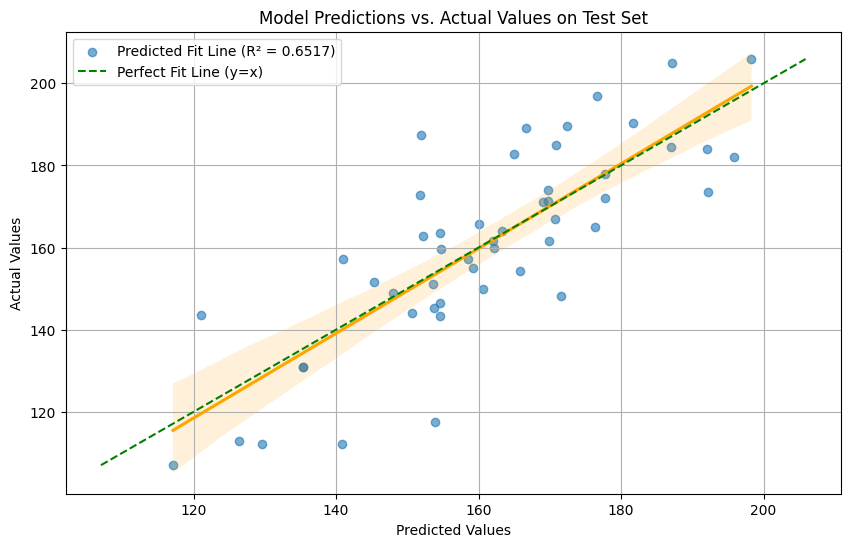

In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# ---- FINAL TEST EVALUATION ----
model.eval()
with torch.no_grad():
    test_output = model(data)
    test_predictions = test_output[test_mask].cpu().numpy()  # Convert to numpy for metric calculation
    test_actuals = data.y[test_mask].cpu().numpy()

# Calculate metrics
mae = mean_absolute_error(test_actuals, test_predictions)
mse = mean_squared_error(test_actuals, test_predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_actuals - test_predictions) / test_actuals)) * 100
r_squared = r2_score(test_actuals, test_predictions)  # Calculate R-squared

# Print all metrics
print("\nFinal Test Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r_squared:.4f}")

# Create DataFrame for year, county, actual, and predicted values
# Assuming `merged_data` contains 'year' and 'county' columns and matches `data`
test_info = merged_data.iloc[test_idx][['year', 'county']]
test_info['actual'] = test_actuals.flatten()
test_info['predicted'] = test_predictions.flatten()

# Save to a CSV file
test_info.to_csv('Datasets/GNN_test_results.csv', index=False)

# Display confirmation
print("\nSaved test results to 'test_results.csv' with columns: year, county, actual, predicted.")

import seaborn as sns
import matplotlib.pyplot as plt

# Convert predictions and actuals to a DataFrame for easier plotting with Seaborn
import seaborn as sns

# Convert predictions and actuals to a DataFrame for easier plotting with Seaborn
results_df = pd.DataFrame({
    'Predicted': test_predictions.flatten(),
    'Actual': test_actuals.flatten()
})

# Plot using Seaborn with a regression line
plt.figure(figsize=(10, 6))

# Scatter plot with predicted fit line
sns.regplot(x='Predicted', y='Actual', data=results_df, ci=95, scatter_kws={'alpha': 0.6}, line_kws={"color": "orange"}, label=f'Predicted Fit Line (R² = {r_squared:.4f})')

# Perfect fit line (y = x)
min_val = min(results_df['Predicted'].min(), results_df['Actual'].min())
max_val = max(results_df['Predicted'].max(), results_df['Actual'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='green', linestyle='--', label='Perfect Fit Line (y=x)')

# Add labels, title, and legend
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Model Predictions vs. Actual Values on Test Set')
plt.legend()
plt.grid(True)
plt.show()

